In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import statsmodels.api as sm
#import statsmodels.formula.api as smf

#custom function
from importData import getData

#Get Data
frizData = getData('C:\\Users\\stweis\\Dropbox\\Penn Post Doc\\Frisbee_Ref_Frames\\data\\batch1\\friz_clean')
    
navData = getData('C:\\Users\\stweis\\Dropbox\\Penn Post Doc\\Frisbee_Ref_Frames\\data\\batch1\\nav_clean')

additionalData = pd.read_excel('C:\\Users\\stweis\\Dropbox\\Penn Post Doc\\Frisbee_Ref_Frames\\data\\batch1\\additionalData_For_Python.xlsx',header=0)
additionalData['participant'] = additionalData['psychopycode']

#Clean data functions
def removeHighRTs(dv,data):
    rtThresh = 2*np.std(data[dv])
    rtMean = np.mean(data[dv])
    dataThresh = data.loc[data[dv] < (rtMean + rtThresh)]
    dataThresh = dataThresh.loc[dataThresh[dv] > 0]
    return dataThresh

def removeWrongAnswers(dv,data):
    dataCorrect = data.loc[data[dv] == 1]
    return dataCorrect


def renameFactorLevels(data,friz_or_nav):
        
    data['condition'] = friz_or_nav
    prompts = sorted(data.prompt1.unique())
    stims = sorted(data.stim1.unique())
    new_stims = ['far_left','far_right','near_left','near_right']

    if friz_or_nav == 'friz':    
        new_prompts = ['Away','Left','Right','Home']
    else:
        new_prompts = ['Away','Home','Left','Right']


    for i in range(len(prompts)):
        data = data.replace(prompts[i],new_prompts[i])
        data = data.replace(stims[i],new_stims[i])
        
    return data


def newFactorPrompts(row):
    if row['prompt1'] == 'Home' or row['prompt1'] == 'Away':
        return 'Absolute'
    else:
        return 'Relative'
    
def newFactorStims(row):
    if row['stim1'] == 'near_right' or row['stim1'] == 'near_left':
        return 'Near'
    else:
        return 'Far'
    


#Clean data
frizData = renameFactorLevels(frizData,'Frisbee')
navData = renameFactorLevels(navData,'Navigation')

frizData['stimLoc'] = frizData.apply(lambda row: newFactorStims(row),axis=1)
navData['stimLoc'] = navData.apply(lambda row: newFactorStims(row),axis=1)

frizData['promptType'] = frizData.apply(lambda row: newFactorPrompts(row),axis=1)
navData['promptType'] = navData.apply(lambda row: newFactorPrompts(row),axis=1)


frizDataThresh = removeHighRTs('Trials_responsert',frizData)
navDataThresh = removeHighRTs('Trials_responsert',navData)

all_answers_data = frizDataThresh.append(navDataThresh)
data = removeWrongAnswers('Trials_responsecorr',all_answers_data)

unthreshed_data = frizData.append(navData)

neccessaryAdditionalData = additionalData.loc[:,
                                              ["Sex","participant",
                                               "SBSOD_AVERAGE",
                                               "Friz_Total_Years_Played",
                                               "Friz_Force_Preference",
                                               "Friz_Position"]]





C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dataForPlot = all_answers_data


# pivots data for plotting

pivoted = dataForPlot.pivot_table(index='participant',columns=['condition','stimLoc','promptType'],values='Trials_responsert',aggfunc=np.mean)

pivoted['Frisbee_Rel_minus_Abs_Far'] = pivoted['Frisbee']['Far']['Relative'] - pivoted['Frisbee']['Far']['Absolute']
pivoted['Frisbee_Rel_minus_Abs_Near'] = pivoted['Frisbee']['Near']['Relative'] - pivoted['Frisbee']['Near']['Absolute']
pivoted['Frisbee_Rel_minus_Abs'] = (pivoted['Frisbee_Rel_minus_Abs_Far'] + pivoted['Frisbee_Rel_minus_Abs_Near'])/2
pivoted['Nav_Rel_minus_Abs_Far'] = pivoted['Navigation']['Far']['Relative'] - pivoted['Navigation']['Far']['Absolute']
pivoted['Nav_Rel_minus_Abs_Near'] = pivoted['Navigation']['Near']['Relative'] - pivoted['Navigation']['Near']['Absolute']
pivoted['Nav_Rel_minus_Abs'] = (pivoted['Nav_Rel_minus_Abs_Far'] + pivoted['Nav_Rel_minus_Abs_Near'])/2

pivotedAllFour = dataForPlot.pivot_table(index='participant',columns=['condition','prompt1'],values='Trials_responsert',aggfunc=np.mean)
pivotedAllFour['Friz_Back_minus_Fore'] = pivotedAllFour['Frisbee']['Left'] - pivotedAllFour['Frisbee']['Right']
pivotedAllFour['Friz_Home_minus_Away'] = pivotedAllFour['Frisbee']['Home'] - pivotedAllFour['Frisbee']['Away']
pivotedAllFour['Nav_Left_minus_Right'] = pivotedAllFour['Navigation']['Left'] - pivotedAllFour['Navigation']['Right']
pivotedAllFour['Nav_Home_minus_Away'] = pivotedAllFour['Navigation']['Home'] - pivotedAllFour['Navigation']['Away']
pivoted.sort_index(inplace=True)
pivotedAllFour.sort_index(inplace=True)

# Merges pivoted data with additional data (columns from necessaryAdditionalData)
grandmean = dataForPlot.pivot_table(index='participant',columns=['condition'],values='Trials_responsert',aggfunc=np.mean)
pivoted['participant'] = pivoted.index
pivoted[['participant']] = pivoted[['participant']].apply(pd.to_numeric)
neccessaryAdditionalData.sort_values('participant',inplace=True)
pivoted.sort_values('participant',inplace=True)
merged = pivoted.merge(neccessaryAdditionalData,on='participant')
grandmean['participant'] = grandmean.index
grandmean[['participant']] = grandmean[['participant']].apply(pd.to_numeric)

merged = merged.merge(grandmean,on='participant')






C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:558: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


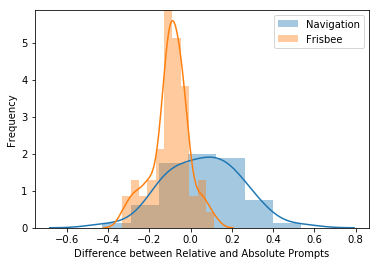

In [3]:
nonaPivoted = pivoted.dropna()
ax1 = sns.distplot(nonaPivoted['Nav_Rel_minus_Abs'],label='Navigation')
sns.distplot(nonaPivoted['Frisbee_Rel_minus_Abs'],label='Frisbee')
ax1.set(xlabel='Difference between Relative and Absolute Prompts',ylabel='Frequency')
plt.legend()
plt.show()